# 0716230 陳子睿

 ## 1. Data Input

## 2. Data Preprocessing

In [1]:
import pandas as pd
import json
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import model_selection 
import random
import json
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
import json
import numpy as np
from sklearn.utils import shuffle
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

import some libraries

### Shuffle the data

In [2]:
with open('train.json') as file:
    data = json.load(file)
    data = shuffle(data , random_state=0)

* code explain <br>
    * load the json file<br>
    * shuffle the data<br>

#### Transform data format and shape (SVM)  AND Data augmentation that can boost your final results (use Tfidf to encode the Data)

In [3]:
def join_all_ings(data, joined_ings_lst):
        stemmer = WordNetLemmatizer()
        for recipe in data:
            temp = ""
            for i in recipe['ingredients']:
                i=i.replace("-", "")
                i=i.replace("&", "")
                i=i.replace("!", "")
                i=i.replace("'", "")
                i=i.replace("%", "")
                i=i.replace("(", "")
                i=i.replace("?", "")
                i=i.replace("(", "")
                i=i.replace(")", "")
                i=i.replace(":", "")
                i=i.replace(",", "")
                i=i.replace(".", "")
                i=i.replace("/", "")
                i=i.replace("$", "")
                i=i.replace("@", "")
                i=i.replace("#", "")
                i=i.replace(u"\u2122", "")
                i=i.replace(u"\u00AE", "")
                i = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", i)
                i=stemmer.lemmatize(i, pos="a")
                temp+=i
                temp+=" "
            temp = temp.strip()
            joined_ings_lst+=[" ".join(temp.split())]
        return joined_ings_lst

def train_cuis(data, cuis_lst):
    for recipe in data:
        cuis_lst+=[recipe['cuisine']]
        cuisines.add(recipe['cuisine'])
    return cuis_lst



ingredients = set()
cuisines = set()

for r in data:
    cuisines.add(r['cuisine'])
    for i in r['ingredients']:
        ingredients.add(i)


X = join_all_ings(data, [])
Y = train_cuis(data, [])

encoder = TfidfVectorizer()
encoder.fit(X)
X = encoder.transform(X)

labelsEncode = LabelEncoder()
labelsEncode.fit(Y)
Y = labelsEncode.transform(Y)

* code explain
    * join_all_ings
        * replace reduntant characters by replace function, for example 1% low fat I will delete the 1% for better result
        * use WordNetLemmatizer to  remove the affixes of the word and extract the main part of the word
        * join all the ingredients into a list which is the feature array
    * train_cuis
        * join all cuisine into a list which is also the target array
    * X = join_all_ings(data, []) -> get feauture array
    * Y = train_cuis(data, []) -> get target array
    * encode the feature using TfidfVectorizer() import from sklearn
    * encode the target(Y) using LabelEncoder()
    * cuisines : join all the cuisine in a list
    * ingredients : join all the ingredients into a list

* Boot result :
    * if use one-hot-encoding, running svm may cause 3 hours a time, however using TfidVectorizer to encode is much faster.

#### Transform data format and shape (ANN) AND Data augmentation that can boost your final results (use Tfidf to encode the Data)

In [4]:
# assign ids to cuisines
cuisine_to_id = {}
id_to_cuisine = {}

counter = 0
for cuisine in cuisines:
    cuisine_to_id[cuisine] = counter
    id_to_cuisine[counter] = cuisine
    counter += 1
    
# assign ids to ingredients
ingredient_to_id = {}
id_to_ingredient = {}

counter = 0
for ingredient in ingredients:
    ingredient_to_id[ingredient] = counter
    id_to_ingredient[counter] = ingredient
    counter += 1

# function that returns X, Y matrices by using shuffled data
def create_supervised_one_hot(data, create_y=True):
    num_samples = len(data)
    num_ingredients = len(ingredients)
    num_cuisines = len(cuisines)
    X = np.zeros(shape=(num_samples, num_ingredients))
    if create_y:
        Y = np.zeros(shape=(num_samples, num_cuisines))
    for i, recipe in enumerate(data):
        for ingredient_in_this in recipe['ingredients']:
            if ingredient_in_this in ingredient_to_id:
                X[i, ingredient_to_id[ingredient_in_this]] = 1.0
        if create_y:
            Y[i, cuisine_to_id[recipe['cuisine']]] = 1.0
    return X, Y

# create X, Y matrices
XNN, YNN = create_supervised_one_hot(data)

* code explain
    * cuisine to id and id to cuisine : like dictionary, use a counter from 0 to map to a cuisine and map cuisine to counter
    * ingredients to id and id to ingredients : same like above
    * create_supervised_one_hot : 
        * np.zeros(shape=(num_samples, num_cuisines)) : initialize the 2d array of X and Y to zero 
        * use for loop to access every ingredients in every cuisine, and if the row has the ingredient mark it to one (one hot encoding)
        * create_supervised_one_hot(data) : create the one hot encode 
        
    

## 3.Model Construction

#### SVM

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm1 = SVC(C=0.1, kernel='linear')
svm2 = SVC(C=0.1, kernel='sigmoid')
svm3 = SVC(C=0.1, kernel='poly')

* code explain
    * construct three svm models with different kernel by sklearn
* comparision is in the result part


#### ANN

In [6]:
def train(X_train, Y_train, X_validation, Y_validation):

        model = Sequential()
        model.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.2))
        model.add(Dense(70, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(Y_train.shape[1], activation='softmax'))
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
        return model
        

* code explain
    * model = Sequential() : construct Sequential model
    * model.add(Dense(200, activation='relu', input_dim=X_train.shape\[1\])) : add input layer and specify activation function and input dimension
    * model.add(Dense(70, activation='relu')) : add hidden layer and specify activation
    * model.add(Dropout(0.1)) -> prevent overfitting
    * model.add(Dense(Y_train.shape\[1\], activation='softmax')) : add output layer and specify activation
    * sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) : construct optimizer with sgd
    * model.compile : compile the keras model

* reasoning of your model choice : I use keras to construct my model for some reasons
    * easy to install compare to tensorflow or others
    * Simply to use and I am quite familiar with it 
    * Keras has great community and calibre Documentation when solving problems
    
    

### Explain the reasoning of your model choice, data augmentation, and training process.

### Holdout validation with the ratio 7:3

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
XNN_train, XNN_test, YNN_train, YNN_test = train_test_split(XNN, YNN, test_size=0.3, shuffle=True)

* code explain 
    * use train_test_split to split data into validation and train data

## 4. Results

In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

def show_confusion_matrix(y_predicted, y_true, label_to_string_map=None):
    labels = np.unique(list(cuisines))
    map_label_to_index = { label : i for i, label in enumerate(labels) } 
    # compute confusion matrix
    confusion_matrix = np.zeros((labels.shape[0], labels.shape[0]), dtype=int)
    for prediction_label, true_label in zip(y_predicted, y_true):
        confusion_matrix[map_label_to_index[true_label], map_label_to_index[prediction_label]] += 1
    # plot confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    fig.suptitle('Confusion matrix', fontsize=20)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    labels_yaxes = [ '{}'.format(label) for label in labels ]
    labels_xaxes = [ '{}'.format(label) for label in labels ]
    ax.set_xticklabels([''] + labels_xaxes)
    ax.set_yticklabels([''] + labels_yaxes)
    im = ax.matshow(confusion_matrix, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    fig.colorbar(im)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(axis='x', labelrotation=60)
    plt.show()

just some libraries and function to visualize confusion matrix

#### SVM with linear kernel  

70.71532519870144


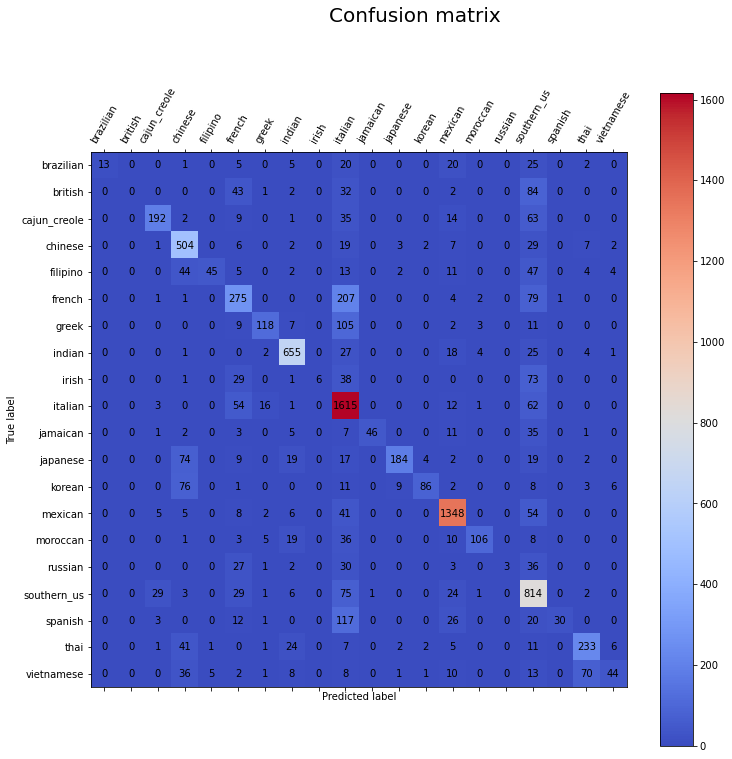



svm1 Accuracy : 0.7072
svm1 Precision : 0.7072
svm1 Sensitivity : 0.7828
              precision    recall  f1-score   support

   brazilian       0.14      1.00      0.25        13
     british       0.00      0.00      0.00         0
cajun_creole       0.61      0.81      0.70       236
     chinese       0.87      0.64      0.73       792
    filipino       0.25      0.88      0.39        51
      french       0.48      0.52      0.50       529
       greek       0.46      0.79      0.58       149
      indian       0.89      0.86      0.87       765
       irish       0.04      1.00      0.08         6
     italian       0.92      0.66      0.76      2460
    jamaican       0.41      0.98      0.58        47
    japanese       0.56      0.92      0.69       201
      korean       0.43      0.91      0.58        95
     mexican       0.92      0.88      0.90      1531
    moroccan       0.56      0.91      0.70       117
     russian       0.03      1.00      0.06         3
 south

In [9]:
svm1.fit(X_train, Y_train)

Y_pred = svm1.predict(X_test)
y_pred= labelsEncode.inverse_transform(Y_pred)
y_true = labelsEncode.inverse_transform(Y_test)

score = accuracy_score(Y_test, Y_pred)
print(score*100)

show_confusion_matrix(y_pred, y_true)
pre = precision_score(y_pred, y_true, average='micro')
acc = accuracy_score(y_pred, y_true)
recall = recall_score(y_pred, y_true, average='macro')

print("\n")
print('svm1 Accuracy : {:.4f}'.format(acc))
print('svm1 Precision : {:.4f}'.format(pre))
print('svm1 Sensitivity : {:.4f}'.format(recall))
print(classification_report(y_pred, y_true))


* code explain 

    * choose the model you want
    * model.fit(X_train, y_train) --> use train data to fit the data <br>
    * y_pred = model.predict(X_test) --> predict y_pred by getting X-test <br>
    * then compare y_test(result) with y_pred (predict result) <br>
    * precision_score(y_test, y_pred)--> get precision <br>
    * accuracy_score(y_test, y_pred) --> get accuracy <br>
    * confusion_matrix(y_test, y_pred) --> get confusion matrix <br>
    * recall_score(y_test, y_pred, average='macro') --> get sensitivity <br>


#### SVM with sigmoid kernel

70.0772416881227


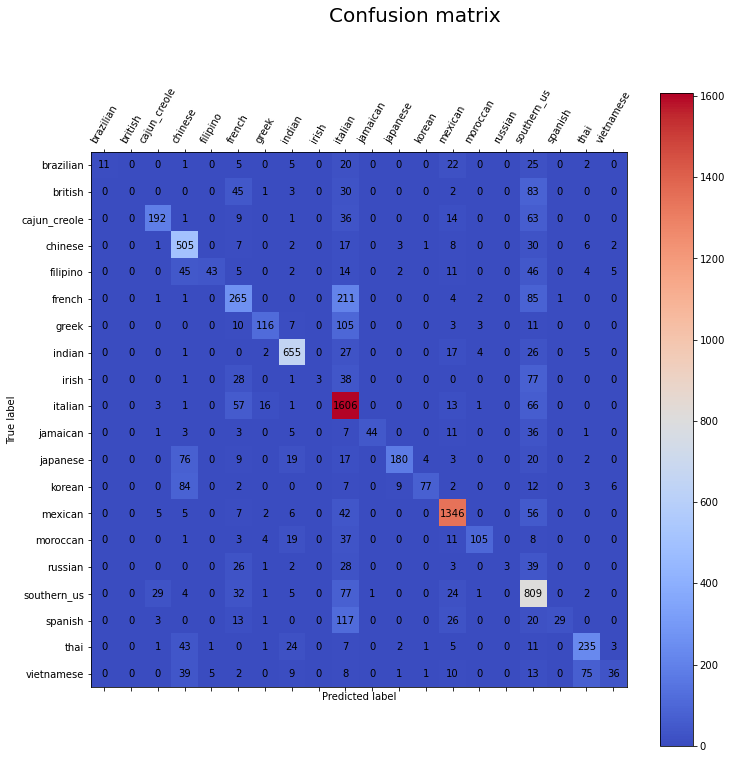



svm2 Accuracy : 0.7008
svm2 Precision : 0.7008
svm2 Sensitivity : 0.7802
              precision    recall  f1-score   support

   brazilian       0.12      1.00      0.22        11
     british       0.00      0.00      0.00         0
cajun_creole       0.61      0.81      0.70       236
     chinese       0.87      0.62      0.73       811
    filipino       0.24      0.88      0.38        49
      french       0.46      0.50      0.48       528
       greek       0.45      0.80      0.58       145
      indian       0.89      0.86      0.87       766
       irish       0.02      1.00      0.04         3
     italian       0.91      0.66      0.76      2451
    jamaican       0.40      0.98      0.56        45
    japanese       0.55      0.91      0.68       197
      korean       0.38      0.92      0.54        84
     mexican       0.92      0.88      0.90      1535
    moroccan       0.56      0.91      0.69       116
     russian       0.03      1.00      0.06         3
 south

In [10]:
svm2.fit(X_train, Y_train)

Y_pred = svm2.predict(X_test)
y_pred= labelsEncode.inverse_transform(Y_pred)
y_true = labelsEncode.inverse_transform(Y_test)

score = accuracy_score(Y_test, Y_pred)
print(score*100)

show_confusion_matrix(y_pred, y_true)
pre = precision_score(y_pred, y_true, average='micro')
acc = accuracy_score(y_pred, y_true)
recall = recall_score(y_pred, y_true, average='macro')

print("\n")
print('svm2 Accuracy : {:.4f}'.format(acc))
print('svm2 Precision : {:.4f}'.format(pre))
print('svm2 Sensitivity : {:.4f}'.format(recall))
print(classification_report(y_pred, y_true))


* code explain
    * same as above svm1

### SVM with polynomial kernel

44.31881786633829


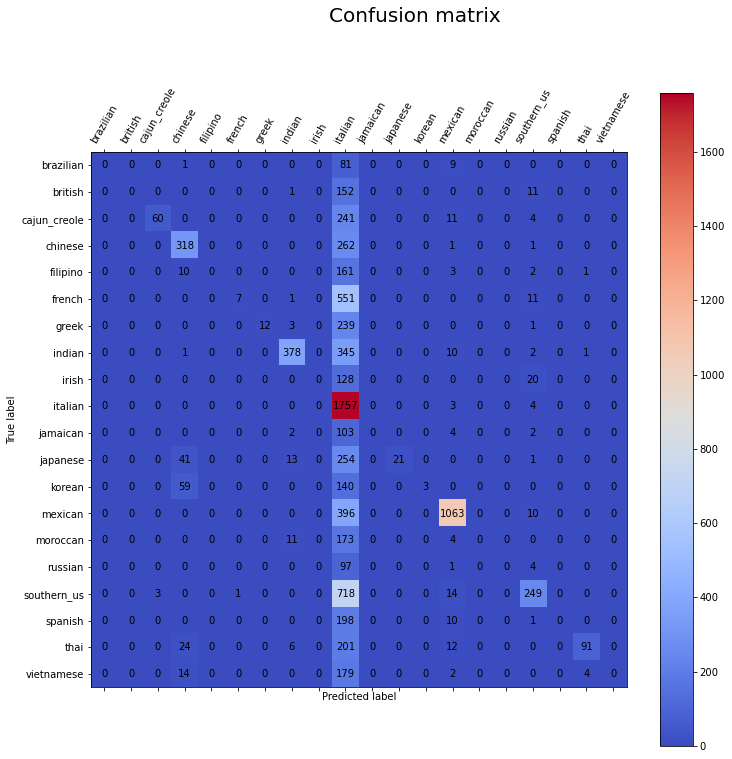



svm1 Accuracy : 0.4432
svm1 Precision : 0.4432
svm1 Sensitivity : 0.4665
              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00         0
     british       0.00      0.00      0.00         0
cajun_creole       0.19      0.95      0.32        63
     chinese       0.55      0.68      0.61       468
    filipino       0.00      0.00      0.00         0
      french       0.01      0.88      0.02         8
       greek       0.05      1.00      0.09        12
      indian       0.51      0.91      0.66       415
       irish       0.00      0.00      0.00         0
     italian       1.00      0.28      0.43      6376
    jamaican       0.00      0.00      0.00         0
    japanese       0.06      1.00      0.12        21
      korean       0.01      1.00      0.03         3
     mexican       0.72      0.93      0.81      1147
    moroccan       0.00      0.00      0.00         0
     russian       0.00      0.00      0.00         0
 south

In [11]:
svm3.fit(X_train, Y_train)

Y_pred = svm3.predict(X_test)
y_pred= labelsEncode.inverse_transform(Y_pred)
y_true = labelsEncode.inverse_transform(Y_test)

score = accuracy_score(Y_test, Y_pred)
print(score*100)

show_confusion_matrix(y_pred, y_true)
pre = precision_score(y_pred, y_true, average='micro')
acc = accuracy_score(y_pred, y_true)
recall = recall_score(y_pred, y_true, average='macro')

print("\n")
print('svm1 Accuracy : {:.4f}'.format(acc))
print('svm1 Precision : {:.4f}'.format(pre))
print('svm1 Sensitivity : {:.4f}'.format(recall))
print(classification_report(y_pred, y_true))


* code explain
    * same as above svm1

#### ANN

In [12]:
nn = train(XNN_train, YNN_train, XNN_test, YNN_test)
history = nn.fit(XNN_train, YNN_train, epochs=100, batch_size=128, verbose=1, validation_data=(XNN_test, YNN_test))

Epoch 1/100
163/163 [==============================] - 3s 18ms/step - loss: 2.5488 - accuracy: 0.2613 - val_loss: 2.1011 - val_accuracy: 0.4290
Epoch 2/100
163/163 [==============================] - 3s 15ms/step - loss: 1.8050 - accuracy: 0.4912 - val_loss: 1.5170 - val_accuracy: 0.5682
Epoch 3/100
163/163 [==============================] - 3s 17ms/step - loss: 1.4395 - accuracy: 0.5858 - val_loss: 1.2797 - val_accuracy: 0.6397
Epoch 4/100
163/163 [==============================] - 3s 17ms/step - loss: 1.2495 - accuracy: 0.6386 - val_loss: 1.1462 - val_accuracy: 0.6750
Epoch 5/100
163/163 [==============================] - 3s 18ms/step - loss: 1.1195 - accuracy: 0.6710 - val_loss: 1.0588 - val_accuracy: 0.6965
Epoch 6/100
163/163 [==============================] - 3s 19ms/step - loss: 1.0281 - accuracy: 0.7009 - val_loss: 0.9963 - val_accuracy: 0.7136
Epoch 7/100
163/163 [==============================] - 3s 18ms/step - loss: 0.9558 - accuracy: 0.7188 - val_loss: 0.9539 - val_accuracy:

* code explain
    * fit the model with arguments
        * epoch : defines the number times that the learning algorithm will work through the entire training dataset. 
        * batch size : defines the number of samples to work through before updating the internal model parameters.
        * verbose : show the bar
        * validation data

## Comparison & Conclusion

#### Three svm with different kernel comparision :

linear : 70% accuracy <br>
sigmoid : 69.9% accuracy <br>
poly : 43% accuracy <br>

Linear and sigmoid kernel has very close accuracy and linear is a little bit higher.

However, my poly kernal svm has a very low accuracy

#### Svm comparision with ANN :

ANN : 96 % accuracy

My ANN model is much higher than all the others models



## Kaggle Submission

In [13]:
def create_supervised_one_hot(infile, create_y=True):
    with open(infile, 'r') as file:
        data = json.load(file)
        num_samples = len(data)
        num_ingredients = len(ingredients)
        num_cuisines = len(cuisines)
        X = np.zeros(shape=(num_samples, num_ingredients))
        if create_y:
            Y = np.zeros(shape=(num_samples, num_cuisines))
        for i, recipe in enumerate(data):
            for ingredient_in_this in recipe['ingredients']:
                if ingredient_in_this in ingredient_to_id:
                    X[i, ingredient_to_id[ingredient_in_this]] = 1.0
            if create_y:
                Y[i, cuisine_to_id[recipe['cuisine']]] = 1.0
        if create_y:
            return X, Y
        else:
            return X


X_final = create_supervised_one_hot('test.json', create_y=False)
ids = []
with open('test.json', 'r') as file:
    data = json.load(file)
    for recipe in data:
        ids.append(recipe['id'])
        
with open('y_test.csv', 'w') as out_file:
    out_file.write('Id,Category\n')
    y_pred = nn.predict(X_final)
    predictions = []
    for i in range(y_pred.shape[0]):
        predictions.append(id_to_cuisine[np.argmax(y_pred[i, :])])
    
    assert len(ids) == len(predictions), 'these should be equal'
    N = len(ids)
    for i in range(N):
        out_file.write('{},{}\n'.format(ids[i], predictions[i]))


#### Take a screenshot of the Leaderboard, highlight your name (chentzj)

![](https://i.imgur.com/BJO1Qyx.png)